This script is for calculating the Dispersive surface energy ($\gamma_{d}^{s}$) of a solid sample from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser).  Measured parameters are imported from a csv file and the dispersive surface energy profile (including error and $R^{2}$ value of the fit) is shown and results are output to a different csv file.

In [30]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats,constants
from __future__ import division

# Input data is sorted to be usable

In [31]:
# reads the experimental data file. note: remove other exp details
# Change nrows and skiprows depending on amount of injections
# skiprows skips the first x rows of csv while nrows reads the first x - 1 rows 
f = pd.read_csv(raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n'),skiprows=8,nrows=112,
                encoding='utf-16', delimiter='\t')

Copy path to input file here 
make sure to insert extra "\" and remove "" 
C:\\Users\\tcd\\Google Drive\\redo new graphene size study with sed recycle april 2016\\IGC\\Raw data\\Surface energy\\1000-1500rpm\\4-alkanes\\1000-1500rpm_4alkanes_90C.csv


In [59]:
# Removes  columns that have all null values
df = f.dropna(axis =1, how='all')

In [33]:
# Get rid of columns unrelated to dispersive solvents
df.drop(df.columns[2:7],axis=1,inplace=True)

In [34]:
# Renames columns to make life easier
df.rename(columns = {'n/nm' : 'n_nm',
                     'Solvent Name' : 'solvent',
                     'Interpolated Retention Volume (Max)' : 'max',
                     'Interpolated Retention Volume (Com)' : 'com',
                     'Column Temperature [Kelvin]': 'temperature (K)'},inplace=True)

In [35]:
# Gets rid of Specifc solvents
# NOTE: IF MORE OR LESS OR DIFFERENT SOLVENTS USED CHANGE THIS LINE ACCORDINGLY
df = df[(df.solvent != 'DICHLOROMETHANE') & (df.solvent != 'ETHYL ACETATE') & (df.solvent != '1,4-DIOXANE')]

In [36]:
# Dictionary for map used in next line
solvent_map = {'NONANE': 9,
               'OCTANE' : 8,
               'HEPTANE' : 7,
               'HEXANE' : 6}

In [58]:
# New columns that maps the carbon number from solvent column. Carbon number is needed for calculations
df['carbon num'] = df['solvent'].map(solvent_map)

C:\Users\tcd\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Calculations

Gibbs Free Energy of adsorption is calculated by $\Delta G=RT\ln V_{n}$ ($\frac{kJol}{Mol})$ where $V_{n}$ is the column called 'com'

In [57]:
# Import real gas const
# RTLnVn is the Gibbs free energy of adsorption
R= constants.R
df['RTLnVn'] = R * df['temperature (K)'] * np.log(df['com'])

C:\Users\tcd\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
# Creates coverage list for the data set
cov = df['n_nm'].unique().tolist()

In [55]:
# List where each element corresponds to part of dataframe with coverage value
cov_sep_list = [df.loc[df.n_nm == i] for i in cov]

In [53]:
# Linear Regression on Gibbs free energy of adsorption vs carbon number
# result is list of tuples containing slope, standard error of slope, r_value etc in a list of tuples
result = [stats.linregress(df['carbon num'],df['RTLnVn']) for df in cov_sep_list]

In [42]:
# Unzips list of tuples to individual tuples
slopes, intercepts,r_values,p_values,std_errs = zip(*result)

In [54]:
# turns tuples to numpy arrays for calculations
slopes = np.array(slopes)

In [44]:
r_values = np.array(r_values)
std_errs = np.array(std_errs)

In [45]:
# Computes R^2 of linear fit
r_sq_arr = r_values ** 2

In [46]:
# values used in surface energy equation (Dorris-Gray)
# T = experiment temperature, y_ch2 = dispersive surface energy of methylene group
# a_ch2 = cross sectional surface area of methylene group

T = f['Column Temperature [Kelvin]'].mean()
y_ch2 = 35.6 + 0.058 * (293 - T)
y_ch2 = y_ch2 / 1000
Na = constants.Avogadro
a_ch2 = 6E-20

Dorris-Gray equation for the calculation of the dispersive surface energy ($\gamma_{d}^{s}$) of a solvent, $unit=\frac{mJ}{m^{2}}$

$$\gamma_{d}^{s}=\frac{1}{4\gamma_{d}^{CH2}}\left(\frac{RT.ln\left[\frac{V_{N,n+1}}{V_{N,n}}\right]}{N_{a}a_{CH2}}\right)^{2}$$

$$\gamma_{d}^{s}=\frac{1}{4\gamma_{d}^{CH2}}\left(\frac{slope}{N_{a}a_{CH2}}\right)^{2}$$

In [47]:
# Dorris-Gray equation for dispersive surface energy
y_d = (1/(4 * y_ch2)) * (slopes/(Na * a_ch2)) ** 2

In [48]:
# Converts from J/m^2 to mJ/m^2
y_d = y_d * 1000

In [49]:
# Calculates error in y_d from standard error in slope of fitting
y_d_err = (y_d * 2 * std_errs) / slopes

# Output and plotting of $\gamma_{d}^{s}$ profile

In [50]:
# Creates dataframe of results with coverage used as index
results_df = DataFrame({'Coverage' : cov,
                       'Dispersive Surface Energy (COM)' : y_d,
                       'Error': y_d_err,
                       'R Square' : r_sq_arr},)
results_df.set_index(keys = 'Coverage',inplace=True)
results_df

,Dispersive Surface Energy (COM),Error,R Square
Coverage,,,
0.0075,132.075024,4.516000,0.999416
0.0100,129.179395,6.834667,0.998602
0.0200,125.901186,4.378239,0.999396
0.0300,120.336710,8.021274,0.997783
0.0500,118.345133,3.650988,0.999524
0.0700,115.696713,3.137181,0.999633
0.0900,113.641147,2.621276,0.999734
0.1000,111.839537,2.489622,0.999752
0.1300,112.189583,1.691343,0.999886


In [51]:
# Exports results to a csv name of your choosing
results_df.to_csv(raw_input('copy output directory you want and put .csv after \n'))

copy output directory you want and put .csv after 
C:\\Users\\tcd\\Google Drive\\redo new graphene size study with sed recycle april 2016\\IGC\\Raw data\\Surface energy\\1000-1500rpm\\4-alkanes\\result2.csv


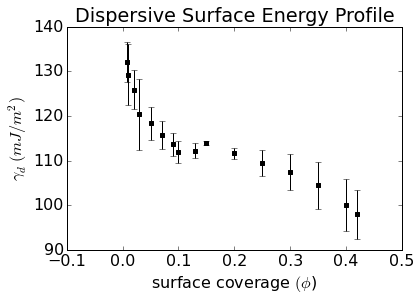

In [52]:
# Plots dispersive surface energy profile with error bars
plt.scatter(cov,y_d,label= 'Dispersive surface energy',c='k',marker='s')
plt.errorbar(cov, y_d,yerr=y_d_err,linestyle = 'None',c='k')
plt.title('Dispersive Surface Energy Profile')
plt.ylabel(r'$\gamma_{d}$ $(mJ/m^{2})$')
plt.xlabel(r'surface coverage $(\phi$)')
plt.rcParams.update({'font.size': 16})